# ML flow:

## Setting up

In [2]:
# run script that installs missing libraries
! chmod 755 ../../scripts.sh
! ../../scripts.sh

# run script that installs missing libraries
! chmod 755 ../../ML_scripts.sh
! ../../ML_scripts.sh

  Using cached cf_units-3.0.1.post0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (491 kB)
  Using cached antlr4_python3_runtime-4.7.2-py3-none-any.whl
  Using cached plotly-5.6.0-py2.py3-none-any.whl (27.7 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)
  Using cached jupyter_dash-0.4.2-py3-none-any.whl (23 kB)
  Using cached dash-2.3.1-py3-none-any.whl (9.6 MB)
  Using cached retrying-1.3.3-py3-none-any.whl
  Using cached Flask-2.1.1-py3-none-any.whl (95 kB)
  Using cached ansi2html-1.7.0-py3-none-any.whl (15 kB)
  Using cached dash_core_components-2.0.0-py3-none-any.whl (3.8 kB)
  Using cached Flask_Compress-1.11-py3-none-any.whl (7.9 kB)
  Using cached dash_html_components-2.0.0-py3-none-any.whl (4.1 kB)
  Using cached dash_table-5.0.0-py3-none-any.whl (3.9 kB)
  Using cached Werkzeug-2.1.1-py3-none-any.whl (224 kB)
  Using cached itsdangerous-2.1.2-py3-none-any.whl (15 kB)
  Using cached Brotli-1.0.9-cp39-cp39-manylinux1_x86_64.whl (357 kB)
  Using cached clo

In [3]:
import os
import sys
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
import rasterio
import cartopy.crs as ccrs
import gcsfs
from tqdm import tqdm
import pyproj
from pyproj import Transformer
from google.cloud import storage
from re import search
from os import listdir
from os.path import isfile, join
from scipy import ndimage
from math import cos,sin,pi

sys.path.append('../')
from process_pangeo import *
from GC_scripts import *
from processRCM import *
from reprojectionFunctions import *
#from MakeInputFunctions import *
from model import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

2022-04-19 06:56:24.557210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-19 06:56:24.557258: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
import torch
import keras
import tensorflow as tf 
from keras import backend as K
from tensorflow.python.keras.backend import set_session

from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Conv2DTranspose, Reshape, concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from netCDF4 import Dataset
import random as rn
from sklearn.model_selection import train_test_split


if torch.cuda.is_available():
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
def plotAllVar(GCM_xy, m=3, n=3, name='GCM', time = 0):
    vars_ = list(GCM_xy.data_vars)
    coords = list(GCM_xy.coords)
    f = plt.figure(figsize=(20, 10))
    map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
    for i in range(len(vars_)):
        var = vars_[i]
        ax = plt.subplot(m, n, i + 1, projection=ccrs.SouthPolarStereo())
        GCM_xy[var].isel(time=time).plot(ax=ax, x='x', y='y',
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)
        ax.coastlines('10m', color='black')
        ax.gridlines()
        ax.set_title(f'{GCM_xy[var].long_name} ({var})')
    plt.suptitle(f'First time step {GCM_xy.time[0].values} of {name}')

## Z and X:

### Z:
- (ignore for now) External forcing also given to RCM → total concentration of greenhouse gases and solar and ozone forcings
- Cosinus, sinus vector to encode information about day of year
- Daily spatial means and standard deviations time series for each $X_{i,j,m}$ (because normalising 2D variables removes temporal information)

### X: 
SHAPE [nbmonths, x, y, nb_vars]

## Load data:

### Input: GCM-like RCM
I.e., to create X, Z

In [6]:
# Path on GC with data:
pathGC = f'Chris_data/RawData/MAR-ACCESS1.3/monthly/'

In [7]:
fileGCMLike = 'MAR(ACCESS1-3)-stereographic_monthly_GCM_like.nc'
downloadFileFromGC(pathGC, '', fileGCMLike)
GCMLike = xr.open_dataset(fileGCMLike)
os.remove(fileGCMLike)
GCMLike.dims

Frozen({'x': 90, 'y': 25, 'time': 1452})

In [8]:
GCMLike

<xarray.Dataset>
Dimensions:      (x: 90, y: 25, time: 1452)
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
Data variables:
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    VVP          (time, y, x) float64 ...
    UUP          (time, y, x) float64 ...
Attributes:
    crs:      3031

### Target: RCM

In [9]:
# Open target file
fileTarget = 'MAR(ACCESS1-3)_monthly.nc'
downloadFileFromGC(pathGC, '', fileTarget)
target_dataset = xr.open_dataset(fileTarget)
os.remove(fileTarget)
target_dataset.dims

Frozen({'time': 1452, 'y': 148, 'x': 176, 'PLEV': 7})

In [83]:
target_dataset

<xarray.Dataset>
Dimensions:      (time: 1452, y: 148, x: 176, PLEV: 7)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
  * PLEV         (PLEV) float32 200.0 500.0 600.0 700.0 800.0 850.0 925.0
Data variables:
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VVP          (time, y, x) float64 ...
    UUP          (time, y, x) float64 ...
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    Conventions:                    CF-1.6
    history:                        Mon Mar  7 10:47:19 2022: ncap2 -O -s RF=...
    institute:                      University of Liege (Belgium)
    contact:                        ckittel@uliege.be
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    ...                             ...
    frequency:                      day
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

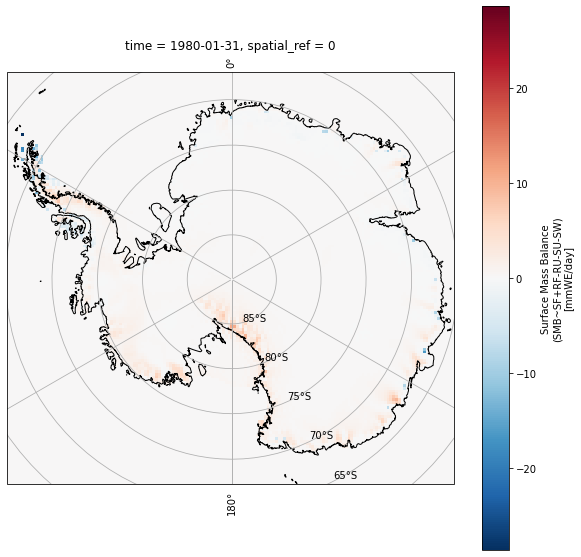

In [115]:
N = 160
max_ = (N/2)*35000

resized = target_dataset.where(target_dataset.x< max_, drop = True)
resized = resized.where(-max_ <= resized.x, drop = True)
resized = resized.where(target_dataset.y< max_, drop = True)
resized = resized.where(-max_ <= resized.y, drop = True)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1 , 1, 1, projection=ccrs.SouthPolarStereo())
resized.SMB.isel(time = 0).plot(x='x', ax = ax, 
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)
    
ax.coastlines('10m', color='black')
ax.gridlines(draw_labels=True)

In [117]:
resized

<xarray.Dataset>
Dimensions:      (time: 1452, y: 148, x: 160, PLEV: 7)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -2.8e+06 -2.765e+06 ... 2.73e+06 2.765e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
  * PLEV         (PLEV) float32 200.0 500.0 600.0 700.0 800.0 850.0 925.0
Data variables:
    RF           (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SP           (time, y, x) float32 999.8 999.6 999.5 ... 985.7 985.9 986.2
    LWD          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SWD          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TT           (time, y, x) float32 5.735 5.514 5.299 ... 3.045 3.182 3.328
    SMB          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VVP          (time, y, x) float64 6.066 5.686 5.358 ... -5.0 -5.258 -5.475
    UUP          (time, y, x) float64 -2.094 -1.85 -1.73 ... 4.135 4.28 4.378
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    Conventions:                    CF-1.6
    history:                        Mon Mar  7 10:47:19 2022: ncap2 -O -s RF=...
    institute:                      University of Liege (Belgium)
    contact:                        ckittel@uliege.be
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    ...                             ...
    frequency:                      day
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

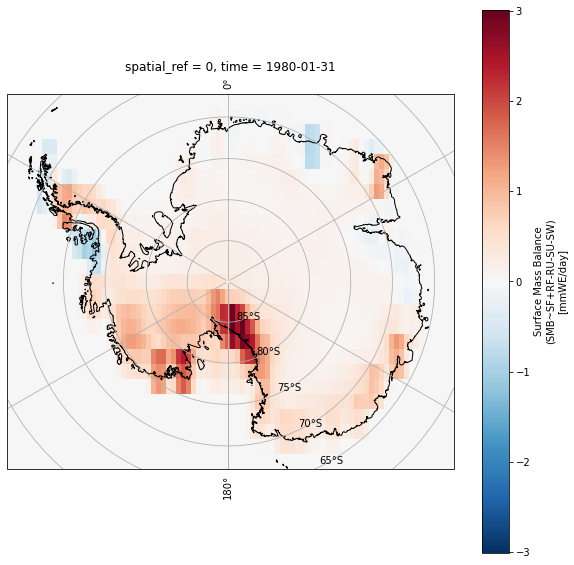

In [66]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1 , 1, 1, projection=ccrs.SouthPolarStereo())
GCMLike.SMB.isel(time = 0).plot(x='x', ax = ax, 
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)
    
ax.coastlines('10m', color='black')
ax.gridlines(draw_labels=True)

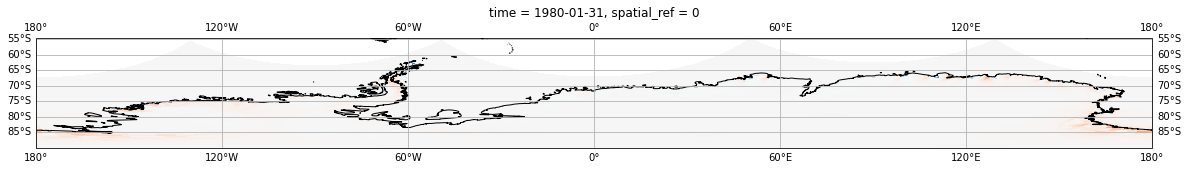

In [72]:
fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(1 , 1, 1, projection=ccrs.PlateCarree())
target_dataset.SMB.isel(time = 0).plot(x='x', ax = ax, 
                transform=ccrs.SouthPolarStereo(), add_colorbar=False)
   

ax.coastlines('10m', color='black')
ax.gridlines(draw_labels=True)

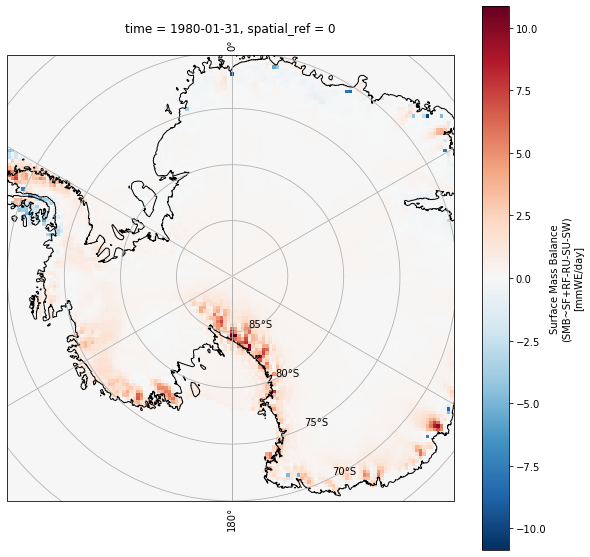

In [111]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1 , 1, 1, projection=ccrs.SouthPolarStereo())
resized.SMB.isel(time = 0).plot(x='x', ax = ax, 
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)
    
ax.coastlines('10m', color='black')
ax.gridlines(draw_labels=True)

## Create input:

In [11]:
def resize(INPUT_2D_bf, size1, size2, print_ = True):
    # resize to input domain size:
    if print_:
        print('Shape before resizing:', INPUT_2D_bf.shape)
    image = tf.constant(INPUT_2D_bf)
    image_resized=tf.image.resize(image,(size1, size2))
    INPUT_2D = image_resized.numpy()
    if print_:
        print('Shape after resizing:', INPUT_2D.shape)
    
    return INPUT_2D

In [15]:
def input_maker(fileGC,
                pathGC, 
                size_input_domain = 16, # size of domain, format: 8,16,32, must be defined in advance 
                stand = True,  # standardization   
                seas = True,   # put a cos, sin vector to control the season, format : bool
                means = True,   # add the mean of the variables raw or stdz, format : bool
                stds = True):   # add the std of the variables raw or stdz, format : bool                
        
    # Download GMC like RCM input data:
    downloadFileFromGC(pathGC, '', fileGC)
    DATASET = xr.open_dataset(fileGC)
    os.remove(fileGC)
    
    ''' 
        MAKE THE 2D INPUT ARRAY
        SHAPE [nbmonths, x, y, nb_vars]
    '''
    print('\nCreating 2D input X:\n -------------------')
    
    # Remove target variable from DATASET:
    DATASET = DATASET.drop(['SMB'])
    
    nbmonths = DATASET.dims['time']
    x = DATASET.dims['x']
    y = DATASET.dims['y']
    nb_vars = len(list(DATASET.data_vars))
    var_list = list(DATASET.data_vars)

    print(f'Number of variables: {nb_vars}')
    print(f'Variables: {var_list}')
    
    INPUT_2D_bf=np.transpose(np.asarray([DATASET[i].values for i in var_list]),[1,2,3,0])
    
    # resize to input domain size:
    if size_input_domain == None:
        size_input_domain= np.max([highestPowerof2(INPUT_2D_bf.shape[1]),highestPowerof2(INPUT_2D_bf.shape[2])])

    INPUT_2D  = resize(INPUT_2D_bf, size_input_domain, size_input_domain)
        
    if stand:
        # Standardize:
        INPUT_2D_SDTZ = standardize(INPUT_2D)
        # in their code with aerosols extra stuff but ignore
        INPUT_2D_ARRAY = INPUT_2D_SDTZ
    else:
        INPUT_2D_ARRAY = INPUT_2D
        
    print(f'INPUT_2D shape: {INPUT_2D_ARRAY.shape}')
    
    
    '''
    MAKE THE 1D INPUT ARRAY
    CONTAINS MEANS, STD SEASON IF ASKED
    '''
    print('\nCreating 1D input Z:\n -------------------')
    
    INPUT_1D = []
    if means and stds:
        vect_std = INPUT_2D.std(axis=(1,2)) 
        vect_means = INPUT_2D.mean(axis=(1,2))
        SpatialMean = vect_means.reshape(INPUT_2D.shape[0],1,1,INPUT_2D.shape[3])
        SpatialSTD = vect_std.reshape(INPUT_2D.shape[0],1,1,INPUT_2D.shape[3])
        
        INPUT_1D.append(SpatialMean)
        INPUT_1D.append(SpatialSTD)
        print(f'SpatialMean/std shape: {SpatialMean.shape}')
        
    if seas : 
        months = 12
        cosvect = np.tile([cos(2*i*pi/months)  for i in range(months)],int(INPUT_2D.shape[0]/months)) 
        sinvect = np.tile([sin(2*i*pi/months)  for i in range(months)],int(INPUT_2D.shape[0]/months)) 
        cosvect = cosvect.reshape(INPUT_2D.shape[0],1,1,1)
        sinvect = sinvect.reshape(INPUT_2D.shape[0],1,1,1)
        
        INPUT_1D.append(cosvect)
        INPUT_1D.append(sinvect)
        print(f'Cos/sin encoding shape: {cosvect.shape}')

    INPUT_1D_ARRAY= np.concatenate(INPUT_1D, axis=3)
    print(f'INPUT_1D shape: {INPUT_1D_ARRAY.shape}')
    
    DATASET.close()
    
    return INPUT_2D_ARRAY, INPUT_1D_ARRAY

In [16]:
fileGCMLike = 'MAR(ACCESS1-3)-stereographic_monthly_GCM_like.nc'

size_input_domain = 16
i2D , i1D  = input_maker(fileGCMLike,
                pathGC, 
                size_input_domain,
                stand = True,  # standardization   
                seas = True,   # put a cos,sin vector to control the season, format : bool
                means = True,   # add the mean of the variables raw or stdz, format : r,s,n
                stds = True)

inputs_2D=[]
inputs_1D=[]
inputs_1D.append(i1D)
inputs_2D.append(i2D)


Creating 2D input X:
 -------------------
Number of variables: 7
Variables: ['RF', 'SP', 'LWD', 'SWD', 'TT', 'VVP', 'UUP']
Shape before resizing: (1452, 25, 90, 7)
Shape after resizing: (1452, 16, 16, 7)
INPUT_2D shape: (1452, 16, 16, 7)

Creating 1D input Z:
 -------------------
SpatialMean/std shape: (1452, 1, 1, 7)
Cos/sin encoding shape: (1452, 1, 1, 1)
INPUT_1D shape: (1452, 1, 1, 16)


## Create target:

In [13]:
target_times=[]
targets=[]

# resize images to sizes used in paper:
#target_size = 64 # 'MBP', a 64*64 grid point used in Doury et al. (2022)

targetArray = target_dataset.SMB.values
targetArray = targetArray.reshape(targetArray.shape[0], targetArray.shape[1], targetArray.shape[2], 1)

# resize to highest power of 2: 
target_size  = np.min([highestPowerof2(targetArray.shape[1]), highestPowerof2(targetArray.shape[2])])

#target_size = highestPowerof2(targetArray.shape[1])
target_size = 64
target_SMB  = resize(targetArray, target_size, target_size)

#targets.append(target_tas.values-273.16) # why do they substract to these values?
targets.append(target_SMB)
target_times.append(target_dataset.time.values)

full_target=np.concatenate(targets,axis=0)

Shape before resizing: (1452, 148, 176, 1)
Shape after resizing: (1452, 64, 64, 1)


## U-Net:

In [14]:
SCENARIO=['HIST' , 'RCP85']
var_list = ['RF', 'SP', 'LWD', 'SWD', 'TT', 'VVP', 'UUP']
var_pred = ['SMB']

In [15]:
# Full input to model
full_input=[np.concatenate(inputs_2D,axis=0),np.concatenate(inputs_1D,axis=0)]

# Full target to model
target_time=np.concatenate(target_times,axis=0)
target_lon=target_dataset['x']
target_lat=target_dataset['y']

print('Shapes of targets and inputs:')
print('Target:', full_target.shape)
print('Input 2D:', full_input[0].shape)
print('Input 1D:', full_input[1].shape)

Shapes of targets and inputs:
Target: (1452, 64, 64, 1)
Input 2D: (1452, 16, 16, 7)
Input 1D: (1452, 1, 1, 16)


### Build U-Net:

In [16]:
## In Doury et al (2022) we chose to mask the over seas values as we are not interested in them, we did so by setting them always to 0.
# Ignore for now....
path_model = 'Results/'

#filter_size = int(full_target.shape[1]/2)
#conv = int(full_target.shape[1]/4)
conv = 32
filter_size = 64
# set seed
seed = 123
rn.seed(seed)

# We use here the unet_maker function defined in make_unet
unet=unet_maker(nb_inputs=len(full_input),
                size_target_domain=full_target.shape[1],
                shape_inputs=[A.shape[1:] for A in full_input],
                filters = filter_size, seed = seed, conv = conv)


LR = 0.005
unet.compile(optimizer=Adam(learning_rate=LR), loss="mse", metrics=[rmse_k])

Arguments to U-Net:
------------------
Nb inputs: 2
Size target domain: 64
Shape inputs: [(16, 16, 7), (1, 1, 16)]
Filters: 64
Conv size: 32
Seed: 123
Size: 16


In [17]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 16, 7)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   256         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 32)   0           ['batch_normalization[0][0]']

### Training and validation separation:

In [18]:
idx_train=rn.sample(range(full_target.shape[0]), int(0.8*full_target.shape[0]))
full_input_train=[full_input[k][idx_train,:,:,:] for k in range(len(full_input))]
full_input_test=[np.delete(full_input[k],idx_train,axis=0) for k in range(len(full_input))]
full_target_train=full_target[idx_train,:,:]
full_target_test=np.delete(full_target,idx_train,axis=0)

print('Shapes of targets and inputs split into test and train:')
print('Target test:', full_target_test.shape)
print('Input 2D test:', full_input_test[0].shape)

print('--')
print('Target train:', full_target_train.shape)
print('Input 2D train:', full_input_train[0].shape)

Shapes of targets and inputs split into test and train:
Target test: (291, 64, 64, 1)
Input 2D test: (291, 16, 16, 7)
--
Target train: (1161, 64, 64, 1)
Input 2D train: (1161, 16, 16, 7)


### Fit model:

In [ ]:
batch_size, epochs = 32, 100
callbacks = [
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.7, patience=4, verbose=1
    ),  ## callbacks to reduce the lr during the training
    EarlyStopping(
        monitor="val_loss", patience=15, verbose=1
    ),  ## Stops the fitting if val_loss does not improve after 15 iterations
    ModelCheckpoint(path_model, monitor="val_loss", verbose=1, save_best_only=True),
]  ## Save only best model

history = unet.fit(full_input_train, full_target_train[:,:,:,None], 
         batch_size=batch_size, epochs=epochs,  
         validation_data=(full_input_test,full_target_test[:,:,:,None]), 
         callbacks = callbacks)

Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 0.8201 - rmse_k: 0.4390
Epoch 1: val_loss improved from inf to 1671039.37500, saving model to Results/


2022-04-15 13:33:12.631096: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Results/assets
37/37 [==============================] - 156s 4s/step - loss: 0.8201 - rmse_k: 0.4390 - val_loss: 1671039.3750 - val_rmse_k: 1010.8730 - lr: 0.0050
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 0.5197 - rmse_k: 0.3123
Epoch 2: val_loss improved from 1671039.37500 to 726.28564, saving model to Results/
INFO:tensorflow:Assets written to: Results/assets
37/37 [==============================] - 147s 4s/step - loss: 0.5197 - rmse_k: 0.3123 - val_loss: 726.2856 - val_rmse_k: 21.5405 - lr: 0.0050
Epoch 3/100
37/37 [==============================] - ETA: 0s - loss: 0.4244 - rmse_k: 0.2581
Epoch 3: val_loss improved from 726.28564 to 20.07092, saving model to Results/
INFO:tensorflow:Assets written to: Results/assets
37/37 [==============================] - 145s 4s/step - loss: 0.4244 - rmse_k: 0.2581 - val_loss: 20.0709 - val_rmse_k: 3.0828 - lr: 0.0050
Epoch 4/100
37/37 [==============================] - ETA: 0s - loss: 

In [ ]:
# list all data in history
print(history.history.keys())

## Predictions:

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['rmse_k'])
plt.plot(history.history['val_rmse_k'])
plt.title('model rmse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# plot predictions:
training_pred = unet.predict(full_input_train)
testing_pred = unet.predict(full_input_test)

In [ ]:
def takeRandomInputs(full_input, full_target, full_prediction):
    randTime = rn.randint(1, len(full_input[0]))
    sample2dtrain = full_input[0][randTime]
    sample1dtrain = full_input[1][randTime]
    
    sampletarget = full_target[randTime]
    samplepred = full_prediction[randTime]
    
    return sample2dtrain, sample1dtrain, sampletarget, samplepred, randTime

sample2dtrain_, sample1dtrain_, sampletarget_, samplepred_, randTime = takeRandomInputs(full_input_train, full_target_train, training_pred)

# resize to original shape: (148, 176) for target and (25, 90) for input
print('Train:\n........')
sample2dtrain = resize(sample2dtrain_, 25, 90)

# resize to 3 channels
print('Target:\n........')
sampletarget_ = sampletarget_.reshape(sampletarget_.shape[0], sampletarget_.shape[1], 1)
sampletarget = resize(sampletarget_, 148, 176)

# prediction:
print('Prediction:\n........')
samplepred_ = samplepred_.reshape(samplepred_.shape[0], samplepred_.shape[1], 1)
samplepred = resize(samplepred_, 148, 176)

In [ ]:
def plotTrain(GCMLike, sample2dtrain, numVar, ax, time):
    list_var = list(GCMLike.keys())
    VAR = list_var[numVar]
    coords = {'y':GCMLike.coords['y'], 'x':GCMLike.coords['x']} 
    dftrain = xr.Dataset(coords=coords, attrs=GCMLike.attrs)
    dftrain[VAR] = xr.Variable(dims=("y", "x"), data=sample2dtrain[:,:,numVar], attrs=GCMLike[VAR].attrs)
    dftrain[VAR].plot(ax=ax, x='x',
                transform=ccrs.SouthPolarStereo(), add_colorbar=True)
    
    ax.coastlines('10m', color='black')
    ax.gridlines()

    ax.set_title(f'{time} Input: {VAR}')
    
def plotTarget(target_dataset, sampletarget, ax):
    coords = {'y':target_dataset.coords['y'], 'x':target_dataset.coords['x']} 
    dftrain = xr.Dataset(coords=coords, attrs=target_dataset.attrs)
    dftrain['SMB'] = xr.Variable(dims=("y", "x"), data=sampletarget[:,:,0], attrs=target_dataset['SMB'].attrs)
    dftrain.SMB.plot(ax=ax, x='x',
                    transform=ccrs.SouthPolarStereo(), add_colorbar=True)
    ax.coastlines('10m', color='black')
    ax.gridlines()
    ax.set_title(f'Target: SMB')
    
def plotPred(target_dataset, samplepred ,ax):
    coords = {'y':target_dataset.coords['y'], 'x':target_dataset.coords['x']} 
    dftrain = xr.Dataset(coords=coords, attrs=target_dataset.attrs)
    dftrain['SMB'] = xr.Variable(dims=("y", "x"), data=samplepred[:,:,0], attrs=target_dataset['SMB'].attrs)
    dftrain.SMB.plot(ax=ax, x='x',
                    transform=ccrs.SouthPolarStereo(), add_colorbar=True)
    ax.coastlines('10m', color='black')
    ax.gridlines()
    ax.set_title(f'Prediction: SMB')

In [ ]:
f = plt.figure(figsize=(20, 30))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)

N = 5
for i in range(N):
    sample2dtrain_, sample1dtrain_, sampletarget_, samplepred_, randTime = takeRandomInputs(full_input_train, full_target_train, training_pred)
    dt = pd.to_datetime([GCMLike.time.isel(time = randTime).values])
    time = str(dt.date[0])
    sample2dtrain = resize(sample2dtrain_, 25, 90, print_=False)
    
    sampletarget_ = sampletarget_.reshape(sampletarget_.shape[0], sampletarget_.shape[1], 1)
    sampletarget = resize(sampletarget_, 148, 176, print_=False)

    samplepred_ = samplepred_.reshape(samplepred_.shape[0], samplepred_.shape[1], 1)
    samplepred = resize(samplepred_, 148, 176, print_=False)
    
    M = 3
    for m in range(M):
        if m == 0:
            ax = plt.subplot(N , M, (i*M)+m+1, projection=ccrs.SouthPolarStereo())
            plotTrain(GCMLike, sample2dtrain, 4, ax, time)
        if m == 1:
            ax = plt.subplot(N , M, (i*M)+m+1, projection=ccrs.SouthPolarStereo())
            plotTarget(target_dataset, sampletarget, ax)
        if m == 2:
            ax = plt.subplot(N , M, (i*M)+m+1, projection=ccrs.SouthPolarStereo())
            plotPred(target_dataset, samplepred ,ax)

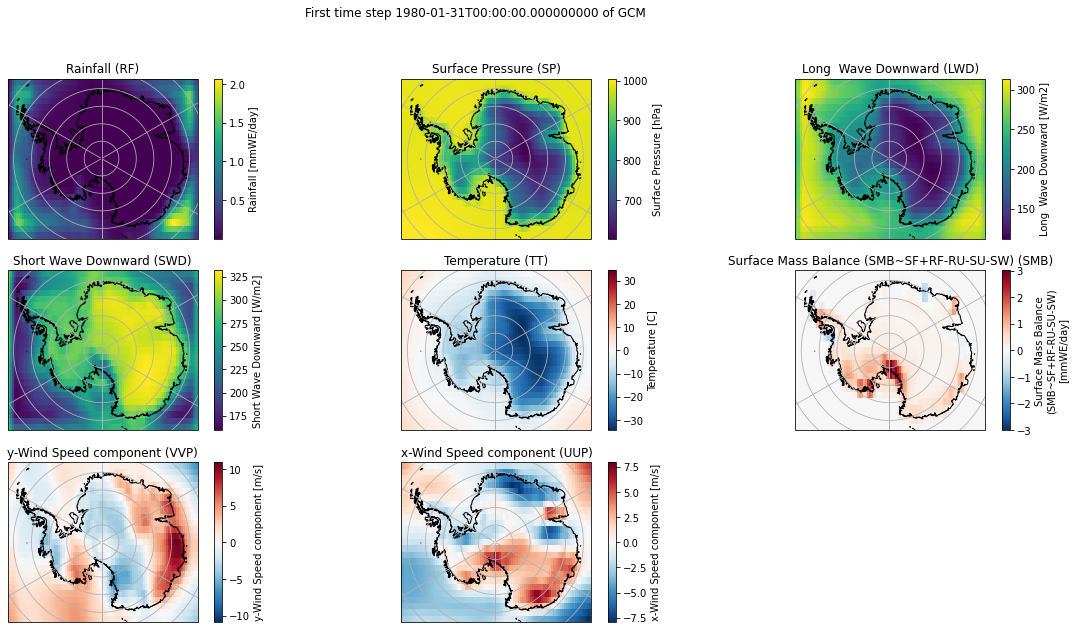

In [61]:
plotAllVar(GCMLike, time = 0)

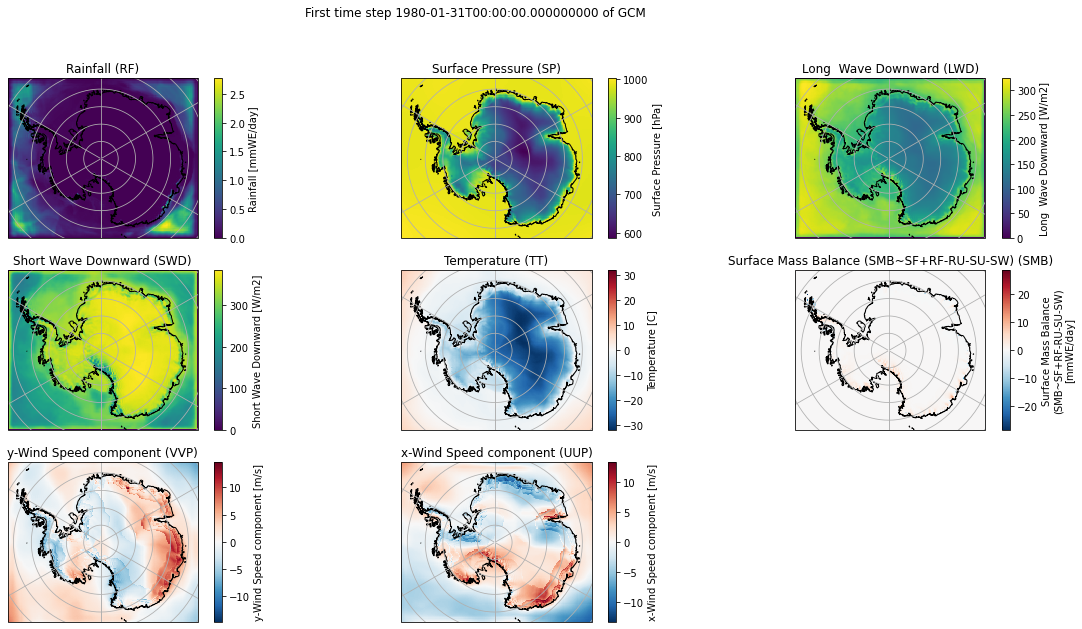

In [60]:
plotAllVar(target_dataset, time = 0)